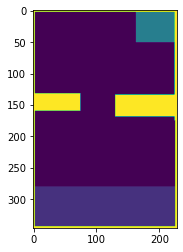

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
import pickle

from collections import defaultdict
import networkx as nx
from scipy.linalg import cholesky
from data.utils import *

with open('data/data.pickle', 'rb') as f:
    data_new = pickle.load(f)
    
env = data_new['env']
obj = data_new['obj']
plt.imshow(env)

In [2]:
import numpy as np
from typing import Union
from scipy.linalg import cholesky

def cov_ellipse(mu, Sigma, color='k', nSigma=1, legend=None):
    """
    Plots a 2D covariance ellipse given the Gaussian distribution parameters.
    The function expects the mean and covariance matrix to ignore the theta parameter.

    :param mu: The mean of the distribution: 2x1 vector.
    :param Sigma: The covariance of the distribution: 2x2 matrix.
    :param color: The border color of the ellipse and of the major and minor axes.
    :param nSigma: The radius of the ellipse in terms of the number of standard deviations (default: 1).
    :param legend: If not None, a legend label to the ellipse will be added to the plot as an attribute.
    """
    mu = np.array(mu)
    assert mu.shape == (2,)
    Sigma = np.array(Sigma)
    assert Sigma.shape == (2, 2)

    n_points = 50

    A = cholesky(Sigma, lower=True)

    angles = np.linspace(0, 2 * np.pi, n_points)
    x_old = nSigma * np.cos(angles)
    y_old = nSigma * np.sin(angles)

    x_y_old = np.stack((x_old, y_old), 1)
    x_y_new = np.matmul(x_y_old, np.transpose(A)) + mu.reshape(1, 2) # (A*x)T = xT * AT
    
    return x_y_new[:, 0], x_y_new[:, 1]

def path_plot(plan,nodes, ellipse_step,graph):
    plt.figure(figsize=(12, 8))

    xaxis = [x[1] for x in plan]
    yaxis = [x[0] for x in plan]
    
    for node in graph.nodes:
        x, y, angle = graph.nodes[node]['val']
        plt.scatter(y,x, linewidth=0.01, color='white')
        
    for i in range(len(plan)):
        if not i % ellipse_step - 1:
            mu = np.array([xaxis[i], yaxis[i]])
            
            matrix = nodes[i].Sigma[:2,:2]
            x_ellipse, y_ellipse = cov_ellipse(mu, matrix)
            plt.plot(x_ellipse, y_ellipse, linewidth=2, color='magenta')
    
    plt.plot(xaxis, yaxis, color='blue', linewidth=2)
    plt.scatter(xaxis[0],yaxis[0],  linewidth=3, color='orange')
    plt.scatter(xaxis[-1], yaxis[-1],linewidth=3, color='red')
    
    plt.imshow(env)

    plt.axis('off')
    plt.show()


In [3]:
def angle_difference(from_ang, to):
    delta_angle =  to - from_ang
    delta_angle = (delta_angle + np.pi) % (2 * np.pi) - np.pi
    return delta_angle
    
def get_distance(state_1,state_2, dis_weight = 1,ang_weight = 20):
    d_xy = np.linalg.norm(state_1[:2] - state_2[:2])
    d_theta = np.abs(angle_difference(state_1[2],state_2[2]))

    return dis_weight * d_xy + ang_weight * d_theta

def steer_func(near_state, final_state,max_xy_step = 20.0, max_angle_step = np.pi/6):
    dir_xy = final_state[:2] - near_state[:2]
    angle = angle_difference(near_state[2],final_state[2])
    new_state = near_state.copy()
    if (np.linalg.norm(dir_xy) < max_xy_step):
        new_state[:2] = final_state[:2]
    else: 
        new_state[:2] += dir_xy * (max_xy_step / np.linalg.norm(dir_xy))
    
    if (np.abs(angle) < max_angle_step):
        new_state[2] += angle
    else: 
        new_state[2] += np.copysign(max_angle_step,angle)
        
    return new_state

def is_state_collision_free(env,mu, Sigma, nSigma = 1,n_points = 6):
    mu = np.array(mu)

    assert mu.shape == (2,)
    Sigma = np.array(Sigma)
    assert Sigma.shape == (2, 2)

    A = cholesky(Sigma, lower=True)

    angles = np.linspace(0, 2 * np.pi, n_points)
    x_old = nSigma * np.cos(angles)
    y_old = nSigma * np.sin(angles)

    x_y_old = np.stack((x_old, y_old), 1)
    x_y_new = np.matmul(x_y_old, np.transpose(A)) + mu.reshape(1, 2) # (A*x)T = xT * AT
    
    
    for xy in x_y_new:
        check_state = tuple(xy.astype(int))
        if(check_state[0] < 0): return False
        if(check_state[0] > env.shape[0]-1): return False
        if(check_state[1] < 0): return False
        if(check_state[1] > env.shape[1]-1): return False
#         print(check_state)
        if (is_point_in_collision(env,check_state,7)):
            return False
    
    return True


news = steer_func(np.array([1,1, 2 * np.pi]),np.array([20,200, 3.0 * np.pi -1e-3]))
print(news)
print(is_state_collision_free(env,(150,200), np.eye(2)*1e-6))
print(is_point_in_collision(env,(150,200),7))

[ 2.90090314 20.90945924  6.80678408]
False
True


In [4]:
def sample_state():
    global x_rng, y_rng,theta_rng 

    key = np.random.rand(1)
    if (key < 0.9):
        x = x_rng.integers(low = 220, high = 300)
        y = y_rng.integers(low = 50, high = 150)
        theta =  2*np.pi * theta_rng.random() - np.pi
        return np.array([x,y,theta])
    
def plot_all_points(env,graph):
    plt.figure(figsize=(10, 8))
    x = 150
    y = 160
    plt.scatter(y, x, linewidth=1, color='red')
#     plt.scatter(1, 1, linewidth=1, color='white')
    for node in graph.nodes:
        x, y, angle = graph.nodes[node]['val']
        if(is_point_in_collision(env,(int(x),int(y) ),7)):
            print((x,y),"is in collision")
        plt.scatter(y, x, linewidth=1, color='white')
    plt.imshow(env)
        
def check_all_points(env,graph):
    for node in graph.nodes:
        x, y, angle = graph.nodes[node]['val']
        if(is_point_in_collision(env,(int(x),int(y) ),7)):
            return False
    return True
    
def find_nearest(graph, random_point):
        min_distance = 1e7
        min_index = None
        
        for index, vert in enumerate(graph.nodes):
            vert = np.array(graph.nodes[vert]['val'])
            distance = get_distance(random_point, vert)
            if distance <= min_distance:
                min_distance = distance
                min_index = index
        
        return min_index
    
def check_sampling_and_steering(n_iter = 2):
    new_vertex_index = -1
    step = 25
    G = nx.DiGraph()
    G.add_node(0, val = np.array([220.0, 50.0, 0.0]))
    for i in range(n_iter):
        if not i % 499:
            print('Iteration:',i, "vertices", len(G.nodes()))

        random_point = sample_state()
        
        nearest_index = find_nearest(G,random_point)
        nearest_state = G.nodes[nearest_index]['val']    
        vertex = steer_func(nearest_state,random_point,step)
        if (is_state_collision_free(env,vertex[:2],np.eye(2))):
            new_vertex_index = len(G.nodes())
            G.add_node(new_vertex_index, val = vertex)
#         self.G.add_edge(nearest_index, new_vertex_index)
    return G

# gr = check_sampling_and_steering(1000)
# print(check_all_points(env,gr))
# plot_all_points(env,gr)

# GRAPH RRBT

In [5]:
from dubins import connect
from propagate import DynamicModel,BeliefNode

class GraphRRTBNX:
    
    def __init__(self, start, end, step=75,k = 650):
        self.start = start
        self.end = end
        self.step = step
#         self.weight = weight
        
        self.G = nx.DiGraph()
        root_belief = [BeliefNode(np.eye(3)*k,np.zeros((3,3)), 0)]
        
        self.G.add_node(0, val = self.start, belief_nodes = root_belief )
    
    def num_of_vertices(self):
        return len(self.G.nodes)
    
    def find_nearest(self, random_point):
        min_distance = 1e7
        min_index = None
        
        for index, vert in enumerate(self.G.nodes):
            vert = np.array(self.G.nodes[vert]['val'])
            distance = get_distance(random_point, vert)
            if distance <= min_distance:
                min_distance = distance
                min_index = index
        
        return min_index
    
    def get_neighbors(self,vertex_id):
        return list(self.G.neighbors(vertex_id))

    def near(self, v_new, radius = None, d = 3):
        n = len(self.G.nodes)

        near_set = []
        if (radius is None):
            radius = calc_radius(n, d)
        
        for vertex in self.G.nodes:
            vertex_coords = np.array(self.G.nodes[vertex]['val'])[:2]
            distance = np.linalg.norm(vertex_coords - v_new[:2])
            if distance <= radius + 1e-3:
                near_set.append(vertex)

        return near_set
    
    def find_predecessors(self, node_index):
        return list(self.G.predecessors(node_index))

    def create_plan(self,radius, test_point = None):
        plan = []
        belief_nodes = []
        
        goal_vertices_indices = self.near(self.end[:2],radius)
             
        best_node = self.G.nodes[goal_vertices_indices[0]]['belief_nodes'][0]
        
        for vertex in goal_vertices_indices:
            for vertex_node in self.G.nodes[vertex]['belief_nodes']:
                if(self.is_candidate_better(best_node,vertex_node, 1e-3)):
                    best_node = vertex_node
        
        plan.append(self.end)
        belief_nodes.append(best_node)
        current_node = best_node
        
        vertex_id = self.get_vertex_for_belief_node(best_node)
        plan.append(self.G.nodes[vertex_id]['val'])
        belief_nodes.append(best_node)
        
        while(current_node != None):
            current_node = current_node.parent
            if (current_node == None):
                break
            vertex_id = self.get_vertex_for_belief_node(current_node)
            plan.append(self.G.nodes[vertex_id]['val'])
            belief_nodes.append(current_node)
        
        plan.reverse()
        belief_nodes.reverse()
        
        return plan,belief_nodes

    def propagate(self,env,edge, start_belief, dt):
        Sigma = start_belief.Sigma
        states = edge[0]
        actions = edge[1]
        state = states[0]
        Lambda = start_belief.Lambda
        xy_error = 0.5
        theta_error = 0.1
        measurement_error = 1
        k = 0.2
        observable_check_const = 1
        kalman = DynamicModel(xy_error, theta_error,measurement_error, dt, k)
        
        check_delta = int(len(actions) / 3)
        if (check_delta < 1e-9): 
            check_delta = 1
        
        for it,action in enumerate(actions):
            kalman.predict(state, action, Sigma)
            Sigma = kalman.Sigma_predicted
            state = kalman.x_predicted
            
            if (not it % check_delta + 1):
                cov_matrix = Sigma
                if not (is_state_collision_free(env,states[it][:2],cov_matrix[:2,:2])):
                    return None
        
            is_observable = is_state_observable(env,tuple(states[it][:2].astype(int)), observable_check_const)
            if (is_observable):
                kalman.update(Lambda,is_observable)
                Sigma = kalman.Sigma_updated
                state = kalman.x_updated
        
        cov_matrix = Sigma #+ Lambda 
        cost = start_belief.cost + len(actions)
#         print(cov_matrix[:2,:2])
        if not (is_state_collision_free(env,states[-1][:2],cov_matrix[:2,:2])):
            return None
        
        return BeliefNode(Sigma, Lambda, cost, parent = start_belief)    
    
    def is_candidate_better(self,current_node,candidate_node, eps = 1e-3):
        
        is_sigma_better =  np.linalg.norm(current_node.Sigma + np.eye(3)*eps) > np.linalg.norm(candidate_node.Sigma)
#         is_lambda_better = np.linalg.norm(current_node.Lambda+np.eye(3)*eps) > np.linalg.norm(candidate_node.Lambda)
#         is_cost_better = current_node.cost > candidate_node.cost
        if (is_sigma_better):
            return True
        else: 
            return False
    
    def get_vertex_for_belief_node(self,belief_node):
        for vertex_id,data in self.G.nodes.data():
            vertex_nodes = data['belief_nodes']
            for node in vertex_nodes:
                if (belief_node == node):
                    return vertex_id
        return None

    def rttb(self, n_iter = 5):
        dt = 1e-2
        new_vertex_index = -1
        for i in range(n_iter):
            if not i % 100:
                print('Iteration:',i, "vertices", self.num_of_vertices())
            
            belief_nodes_to_explore = []
            random_point = self.sample_state()

            nearest_index = self.find_nearest(random_point)
            nearest_state = self.G.nodes[nearest_index]['val']    
            vertex = steer_func(nearest_state,random_point,self.step)
            
            if (not is_state_collision_free(env,vertex[:2],np.eye(2))):
                continue
                
            path = connect(self.G.nodes[nearest_index]['val'], vertex, dt, plot = False)
            propagated = False
            
            for belief_node in self.G.nodes[nearest_index]['belief_nodes']:
                candidate = self.propagate(env,path, belief_node, dt)
                if(candidate != None):
                    propagated = True
                    new_vertex_index = self.num_of_vertices()
                    self.G.add_node(new_vertex_index, val = vertex,belief_nodes= [candidate])
                    self.G.add_edge(nearest_index, new_vertex_index)
                    belief_nodes_to_explore += self.G.nodes[nearest_index]['belief_nodes'] 
                    break
            if (not propagated):
                continue
            
            near_vertices_indices = self.near(vertex)
            
            try:
                near_vertices_indices.remove(nearest_index)
            except Exception as e:
                pass

            for index in near_vertices_indices:
                if index != new_vertex_index:
                    self.G.add_edge(index, new_vertex_index)
                    belief_nodes_to_explore += self.G.nodes[index]['belief_nodes'] 
            
            while(belief_nodes_to_explore):
                current_node = belief_nodes_to_explore.pop()
                vertex_id = self.get_vertex_for_belief_node(current_node)
                for neigh_vertex in self.get_neighbors(vertex_id):
                    path_from_node_to_neigh = connect(self.G.nodes[vertex_id]['val'],
                                                      self.G.nodes[neigh_vertex]['val'],
                                                      dt, plot = False)
                    candidate = self.propagate(env,path_from_node_to_neigh, current_node, dt)
                    if(candidate != None):
                        vertex_node = self.G.nodes[neigh_vertex]['belief_nodes'][0]
                        if(self.is_candidate_better(vertex_node,candidate,0)):
                            self.G.nodes[neigh_vertex]['belief_nodes'].insert(0,candidate)
                            belief_nodes_to_explore +=  [candidate]
                            if (len(self.G.nodes[neigh_vertex]['belief_nodes']) > 3):
                                self.G.nodes[neigh_vertex]['belief_nodes'].pop()
            
    def sample_state(self):
        global x_rng, y_rng,theta_rng 

        key = np.random.rand(1)
        if (key < 0.9):
            x = x_rng.integers(low = 80, high = env.shape[0] - 50) #env.shape[0] - 2
            y = y_rng.integers(low = 40, high = 200) #env.shape[1] - 2
            theta =  2*np.pi * theta_rng.random() - np.pi
            return np.array([x,y,theta])
        else:
            return self.end

In [6]:
#uniform generators initialization
x_rng = np.random.default_rng(seed = 3)
y_rng = np.random.default_rng(seed = 6)
theta_rng = np.random.default_rng(seed = 10)

def calc_radius(n: int, d: int = 3) -> float:
    radius = (np.log(n) / n) ** (1 / d) * 1
    return radius

initial_point = np.array([190.0, 100.0, np.pi/2])
# finish_point = np.array([120.0, 110.0, 0.0])
finish_point = np.array([100.0, 140.0, np.pi/2])
# finish_point = np.array([250.0, 170.0, np.pi/2])
step = 10 
initial_covariance_matrix = 800 # in order to make pass impossible

g = GraphRRTBNX(initial_point, finish_point,  step, initial_covariance_matrix)

g.rttb(2500)

Iteration: 0 vertices 1
Iteration: 100 vertices 82
Iteration: 200 vertices 170


[[800.   0.   0.]
 [  0. 800.   0.]
 [  0.   0. 800.]]
[[9.99800080e-05 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99800080e-05 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.99001995e-05]]


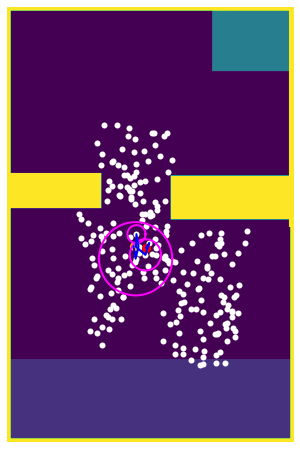

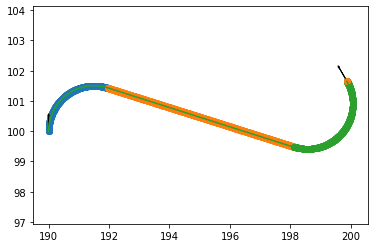

1290
[191. 110.] [[9.9980008e-05 0.0000000e+00]
 [0.0000000e+00 9.9980008e-05]]
True


In [7]:
goal_radius = 10

try:
    plan,nodes = g.create_plan(goal_radius)
except:
    print("probably not enough iterations")

#we are interested to decrease the SIgma matrix
print(nodes[0].Sigma)
print(nodes[-1].Sigma)

ellipses_steps = 2
path_plot(plan, nodes,ellipses_steps, g.G)

# get Dubins path
dt = 1e-2
r = 1.5
states,actions = connect(plan[0], plan[1],r, dt, plot = True)
print(len(states)) # to 10 points
# end of Dubins path

#collision check utils
plan_step_to_check = -1
state_to_check = plan[plan_step_to_check][:2]
cov_matr = nodes[plan_step_to_check].Sigma[:2,:2]

print(state_to_check, cov_matr)
print(is_state_collision_free(env,state_to_check, cov_matr))
#end of collision check utils